In [2]:
# prepare the R environment
if (!require("pacman")) install.packages("pacman")
pacman::p_load(
  dplyr,         # Data munging functions
  zoo,              # Feature engineering rolling aggregates
  data.table,       # Feature engineering
  ggplot2,          # Graphics
  scales,           # Time formatted axis
  readr,            # Reading input files
  stringr,          # String functions
  reshape2,         # restructure and aggregate data 
  randomForest,     # Random forests
  corrplot,         # correlation plots
  Metrics,          # Eval metrics for ML
  vcd               # Visualizing discrete distributions
)

# set options for plots
options(repr.plot.width=6, repr.plot.height=6)

Loading required package: pacman
Warning message:
"package 'pacman' was built under R version 3.5.1"Installing package into 'C:/Program Files/R/R-3.5.1/library'
(as 'lib' is unspecified)
Warning message in utils::install.packages(package, ...):
"'lib = "C:/Program Files/R/R-3.5.1/library"' is not writable"

ERROR: Error in utils::install.packages(package, ...): unable to install packages


In [3]:
# Load the googs data
googFile <-"C:\\Users\\Mirela\\RStudioProjects\\Regression_file\\Regression_Data\\goog.csv"
nasdaqFile<-"C:\\Users\\Mirela\\RStudioProjects\\Regression_file\\Regression_Data\\Nasdaq.csv"
tbondsFile <-"C:\\Users\\Mirela\\RStudioProjects\\Regression_file\\Regression_Data\\tbond5yr.csv"
if(!file.exists(googFile)){tryCatch(googFile)}
if(file.exists(googFile)) goog_original <- read.csv(googFile)
if(!file.exists(nasdaqFile)){tryCatch(nasdaqFile)}
if(file.exists(nasdaqFile)) nasdaqFile_original <- read.csv(nasdaqFile)
if(!file.exists(tbondsFile)){tryCatch(tbondsFile)}
if(file.exists(tbondsFile)) tbondsFile_original <- read.csv(tbondsFile)
head(goog_original)
head(nasdaqFile_original)


Date,Open,High,Low,Close,Volume,Adj.Close
2016-02-01,750.46,757.860,743.27,752.00,10278400,752.00
2016-01-04,743.00,752.000,673.26,742.95,2632600,742.95
2015-12-01,747.11,779.980,724.17,758.88,2026100,758.88
2015-11-02,711.06,762.708,705.85,742.60,1801600,742.60
2015-10-01,608.37,730.000,599.85,710.81,2333600,710.81
2015-09-01,602.36,650.900,589.38,608.42,2398400,608.42


Date,Open,High,Low,Close,Volume,Adj.Close
2016-02-01,4587.59,4636.93,4565.37,4620.37,3966680000,4620.37
2016-01-04,4897.65,4926.73,4313.39,4613.95,2499720000,4613.95
2015-12-01,5129.64,5176.77,4871.59,5007.41,1911610000,5007.41
2015-11-02,5065.64,5163.47,4908.66,5108.67,1951903500,5108.67
2015-10-01,4624.46,5095.69,4552.34,5053.75,2016574000,5053.75
2015-09-01,4673.61,4960.87,4487.06,4620.16,2090584200,4620.16


In [4]:
# generate an id column for future use (joins etc)
goog_original$goog_id = seq.int(nrow(goog_original))
nasdaqFile_original$nasdaq_id = seq.int(nrow(nasdaqFile_original))
head(goog_original)
summary(goog_original)
head(nasdaqFile_original)
summary(nasdaqFile_original)

Date,Open,High,Low,Close,Volume,Adj.Close,goog_id
2016-02-01,750.46,757.860,743.27,752.00,10278400,752.00,1
2016-01-04,743.00,752.000,673.26,742.95,2632600,742.95,2
2015-12-01,747.11,779.980,724.17,758.88,2026100,758.88,3
2015-11-02,711.06,762.708,705.85,742.60,1801600,742.60,4
2015-10-01,608.37,730.000,599.85,710.81,2333600,710.81,5
2015-09-01,602.36,650.900,589.38,608.42,2398400,608.42,6


         Date         Open             High             Low        
 2010-01-04: 1   Min.   : 445.3   Min.   : 497.5   Min.   : 433.6  
 2010-02-01: 1   1st Qu.: 542.0   1st Qu.: 581.4   1st Qu.: 518.9  
 2010-03-01: 1   Median : 598.2   Median : 630.2   Median : 562.2  
 2010-04-01: 1   Mean   : 654.0   Mean   : 692.2   Mean   : 616.0  
 2010-05-03: 1   3rd Qu.: 717.3   3rd Qu.: 760.2   3rd Qu.: 673.4  
 2010-06-01: 1   Max.   :1206.8   Max.   :1228.9   Max.   :1128.0  
 (Other)   :68                                                     
     Close            Volume           Adj.Close        goog_id     
 Min.   : 445.0   Min.   : 1368600   Min.   :222.3   Min.   : 1.00  
 1st Qu.: 542.4   1st Qu.: 2684900   1st Qu.:293.8   1st Qu.:19.25  
 Median : 596.7   Median : 4726750   Median :387.1   Median :37.50  
 Mean   : 654.7   Mean   : 4681997   Mean   :424.1   Mean   :37.50  
 3rd Qu.: 734.7   3rd Qu.: 5979050   3rd Qu.:554.7   3rd Qu.:55.75  
 Max.   :1215.7   Max.   :10278400   Max. 

Date,Open,High,Low,Close,Volume,Adj.Close,nasdaq_id
2016-02-01,4587.59,4636.93,4565.37,4620.37,3966680000,4620.37,1
2016-01-04,4897.65,4926.73,4313.39,4613.95,2499720000,4613.95,2
2015-12-01,5129.64,5176.77,4871.59,5007.41,1911610000,5007.41,3
2015-11-02,5065.64,5163.47,4908.66,5108.67,1951903500,5108.67,4
2015-10-01,4624.46,5095.69,4552.34,5053.75,2016574000,5053.75,5
2015-09-01,4673.61,4960.87,4487.06,4620.16,2090584200,4620.16,6


         Date         Open           High           Low           Close     
 2010-01-04: 1   Min.   :2111   Min.   :2252   Min.   :2061   Min.   :2109  
 2010-02-01: 1   1st Qu.:2732   1st Qu.:2810   1st Qu.:2609   1st Qu.:2761  
 2010-03-01: 1   Median :3137   Median :3205   Median :3091   Median :3151  
 2010-04-01: 1   Mean   :3495   Mean   :3610   Mean   :3367   Mean   :3521  
 2010-05-03: 1   3rd Qu.:4409   3rd Qu.:4557   3rd Qu.:4271   3rd Qu.:4472  
 2010-06-01: 1   Max.   :5134   Max.   :5232   Max.   :4956   Max.   :5128  
 (Other)   :68                                                              
     Volume            Adj.Close      nasdaq_id    
 Min.   :1.557e+09   Min.   :2109   Min.   : 1.00  
 1st Qu.:1.863e+09   1st Qu.:2761   1st Qu.:19.25  
 Median :1.982e+09   Median :3151   Median :37.50  
 Mean   :2.043e+09   Mean   :3521   Mean   :37.50  
 3rd Qu.:2.121e+09   3rd Qu.:4472   3rd Qu.:55.75  
 Max.   :3.967e+09   Max.   :5128   Max.   :74.00  
                    

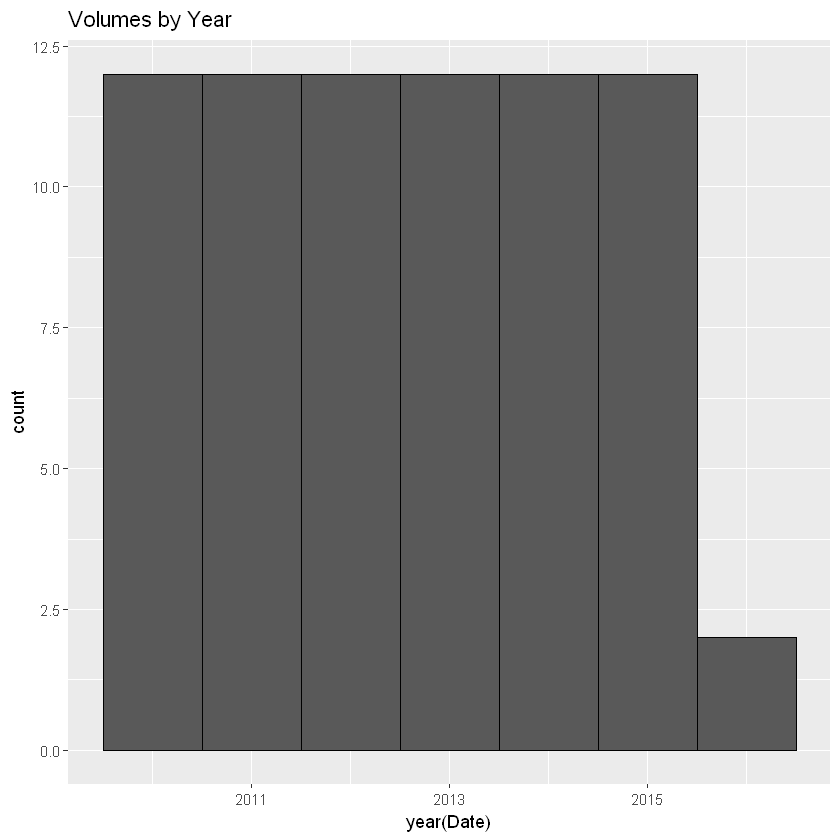

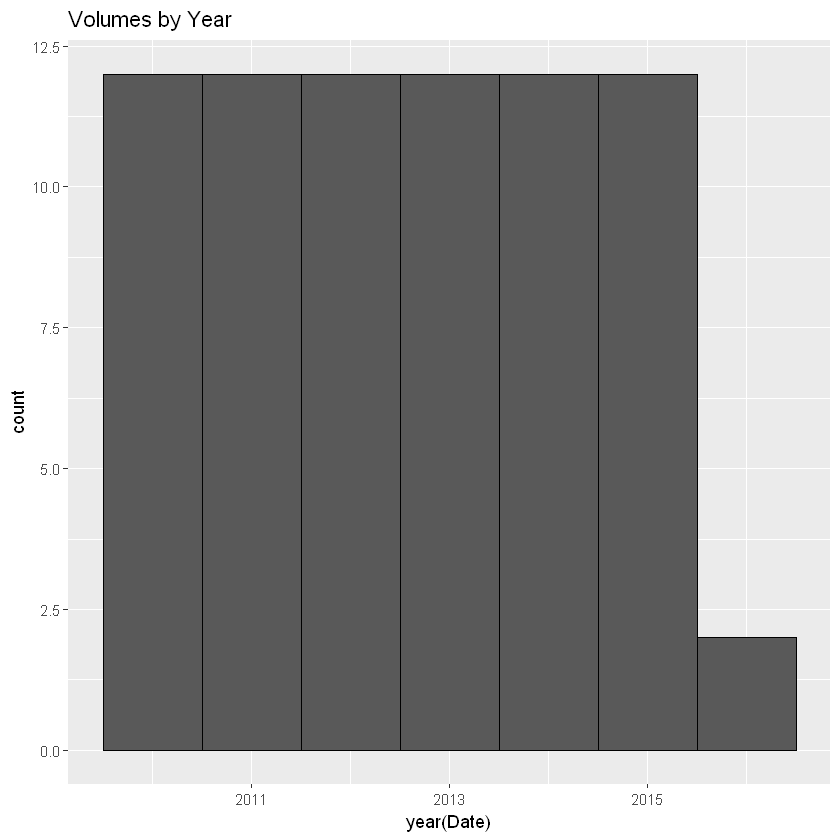

In [5]:
# how many volumes have been realized over the years?
goog_original %>% 
  ggplot(mapping = aes(year(Date))) +
  geom_bar(aes(fill= Volume), width=1, color="black") +
  theme(legend.position = "bottom", legend.direction = "vertical") + ggtitle("Volumes by Year")
nasdaqFile_original %>% 
  ggplot(mapping = aes(year(Date))) +
  geom_bar(aes(fill= Volume), width=1, color="black") +
  theme(legend.position = "bottom", legend.direction = "vertical") + ggtitle("Volumes by Year")

In [7]:
# eliminate any duplicates that may exist in the dataset
googs <- goog_original%>%
  distinct(.keep_all = TRUE,Date,Volume,Adj.Close)
nasdaqs <- nasdaqFile_original%>%
  distinct(.keep_all = TRUE,Date,Volume,Adj.Close)
head(googs)
summary(googs)
head(nasdaqs)
summary(nasdaqs)

Date,Open,High,Low,Close,Volume,Adj.Close,goog_id
2016-02-01,750.46,757.860,743.27,752.00,10278400,752.00,1
2016-01-04,743.00,752.000,673.26,742.95,2632600,742.95,2
2015-12-01,747.11,779.980,724.17,758.88,2026100,758.88,3
2015-11-02,711.06,762.708,705.85,742.60,1801600,742.60,4
2015-10-01,608.37,730.000,599.85,710.81,2333600,710.81,5
2015-09-01,602.36,650.900,589.38,608.42,2398400,608.42,6


         Date         Open             High             Low        
 2010-01-04: 1   Min.   : 445.3   Min.   : 497.5   Min.   : 433.6  
 2010-02-01: 1   1st Qu.: 542.0   1st Qu.: 581.4   1st Qu.: 518.9  
 2010-03-01: 1   Median : 598.2   Median : 630.2   Median : 562.2  
 2010-04-01: 1   Mean   : 654.0   Mean   : 692.2   Mean   : 616.0  
 2010-05-03: 1   3rd Qu.: 717.3   3rd Qu.: 760.2   3rd Qu.: 673.4  
 2010-06-01: 1   Max.   :1206.8   Max.   :1228.9   Max.   :1128.0  
 (Other)   :68                                                     
     Close            Volume           Adj.Close        goog_id     
 Min.   : 445.0   Min.   : 1368600   Min.   :222.3   Min.   : 1.00  
 1st Qu.: 542.4   1st Qu.: 2684900   1st Qu.:293.8   1st Qu.:19.25  
 Median : 596.7   Median : 4726750   Median :387.1   Median :37.50  
 Mean   : 654.7   Mean   : 4681997   Mean   :424.1   Mean   :37.50  
 3rd Qu.: 734.7   3rd Qu.: 5979050   3rd Qu.:554.7   3rd Qu.:55.75  
 Max.   :1215.7   Max.   :10278400   Max. 

Date,Open,High,Low,Close,Volume,Adj.Close,nasdaq_id
2016-02-01,4587.59,4636.93,4565.37,4620.37,3966680000,4620.37,1
2016-01-04,4897.65,4926.73,4313.39,4613.95,2499720000,4613.95,2
2015-12-01,5129.64,5176.77,4871.59,5007.41,1911610000,5007.41,3
2015-11-02,5065.64,5163.47,4908.66,5108.67,1951903500,5108.67,4
2015-10-01,4624.46,5095.69,4552.34,5053.75,2016574000,5053.75,5
2015-09-01,4673.61,4960.87,4487.06,4620.16,2090584200,4620.16,6


         Date         Open           High           Low           Close     
 2010-01-04: 1   Min.   :2111   Min.   :2252   Min.   :2061   Min.   :2109  
 2010-02-01: 1   1st Qu.:2732   1st Qu.:2810   1st Qu.:2609   1st Qu.:2761  
 2010-03-01: 1   Median :3137   Median :3205   Median :3091   Median :3151  
 2010-04-01: 1   Mean   :3495   Mean   :3610   Mean   :3367   Mean   :3521  
 2010-05-03: 1   3rd Qu.:4409   3rd Qu.:4557   3rd Qu.:4271   3rd Qu.:4472  
 2010-06-01: 1   Max.   :5134   Max.   :5232   Max.   :4956   Max.   :5128  
 (Other)   :68                                                              
     Volume            Adj.Close      nasdaq_id    
 Min.   :1.557e+09   Min.   :2109   Min.   : 1.00  
 1st Qu.:1.863e+09   1st Qu.:2761   1st Qu.:19.25  
 Median :1.982e+09   Median :3151   Median :37.50  
 Mean   :2.043e+09   Mean   :3521   Mean   :37.50  
 3rd Qu.:2.121e+09   3rd Qu.:4472   3rd Qu.:55.75  
 Max.   :3.967e+09   Max.   :5128   Max.   :74.00  
                    

In [8]:
googTable <-read.table(googFile,header = TRUE, sep ="," )[,c("Date","Adj.Close")]
nasdaqTable <- read.table(nasdaqFile,header = TRUE, sep = ",")[,c("Date","Adj.Close")]
tbondsTable <- read.table(tbondsFile, header = TRUE, sep = ",")[,c("Date","Adj.Close")]
names(tbondsTable)[2] <- "tbonds.outcomes"
tbondsTable[,c("Date")]<- as.character.Date(tbondsTable[,c("Date")])
googTable <- merge(googTable,nasdaqTable, by="Date")
googTable[,c("Date")]<- as.character.Date(googTable[,c("Date")])
googTable <- googTable[order(googTable$Date,decreasing = TRUE),]
names(googTable)[2:3] <- c("goog.prices","nasdaq.prices")
googTable[-nrow(googTable),-1] <- googTable[-nrow(googTable),-1]/googTable[-1,-1]-1
googTable<-googTable[-nrow(googTable),]
names(googTable)[2:3] <- c("goog.outcomes","nasdaq.outcomes")
googTable<-merge(googTable,tbondsTable,by="Date")
googTable$tbonds.outcomes<-googTable$tbonds.outcomes/100
googTable[,c("goog.outcomes","nasdaq.outcomes")] <- googTable[,c("goog.outcomes","nasdaq.outcomes")]-googTable[,"tbonds.outcomes"]

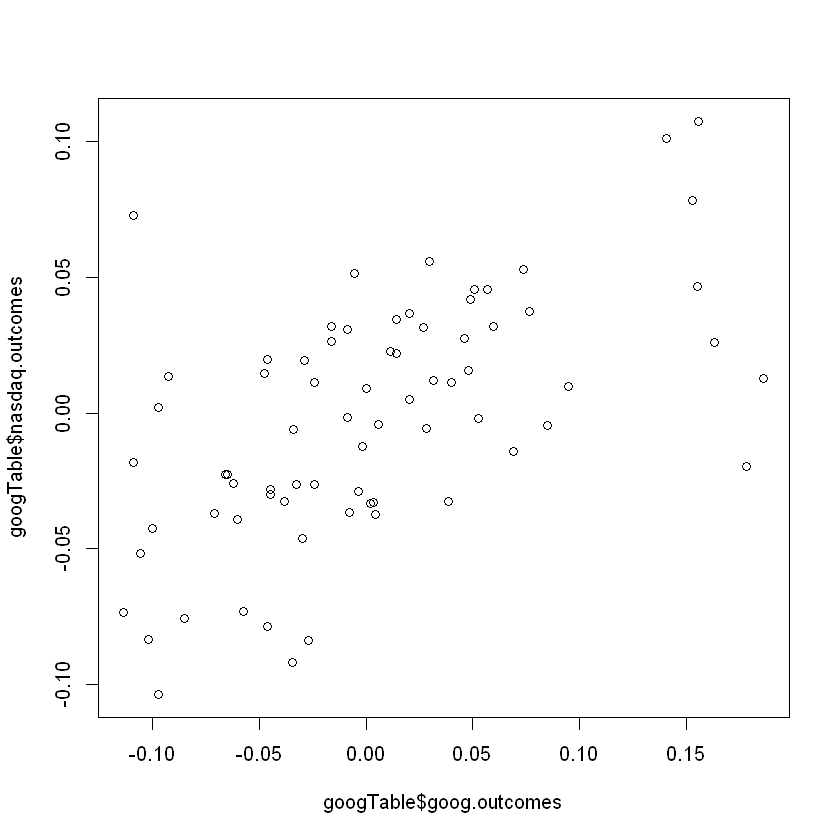

In [9]:
#Robust linear regression 
plot(googTable$goog.outcomes,googTable$nasdaq.outcomes)


Call:
lm(formula = googTable$goog.outcomes ~ googTable$nasdaq.outcomes)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.184265 -0.040596 -0.002853  0.028320  0.192225 

Coefficients:
                          Estimate Std. Error t value Pr(>|t|)    
(Intercept)               0.005303   0.007086   0.748    0.457    
googTable$nasdaq.outcomes 0.958860   0.160220   5.985 8.02e-08 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.06046 on 71 degrees of freedom
Multiple R-squared:  0.3353,	Adjusted R-squared:  0.3259 
F-statistic: 35.82 on 1 and 71 DF,  p-value: 8.018e-08


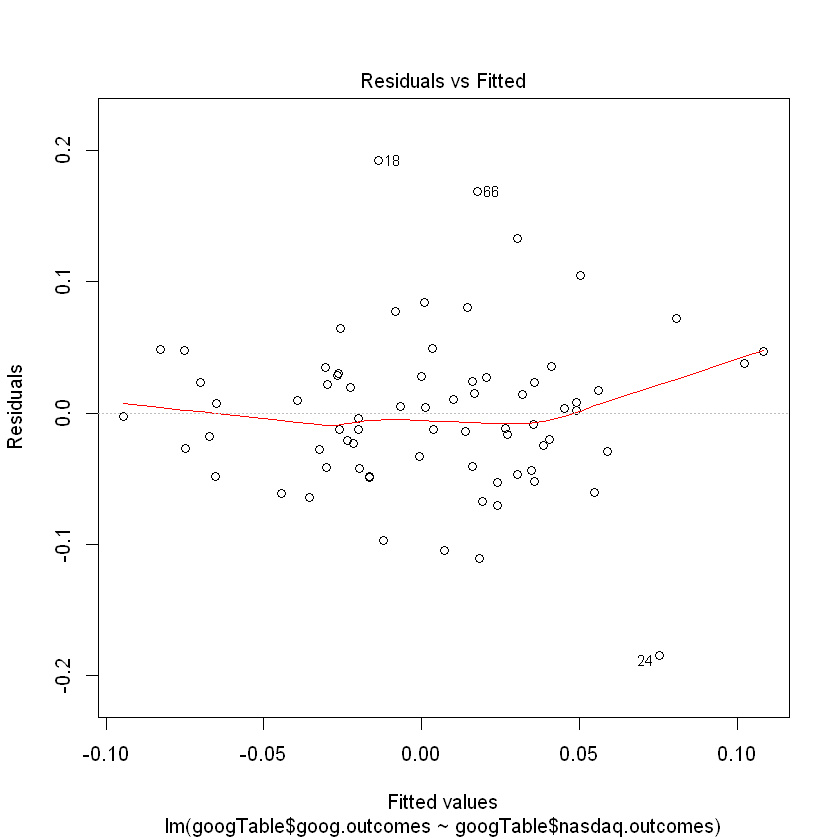

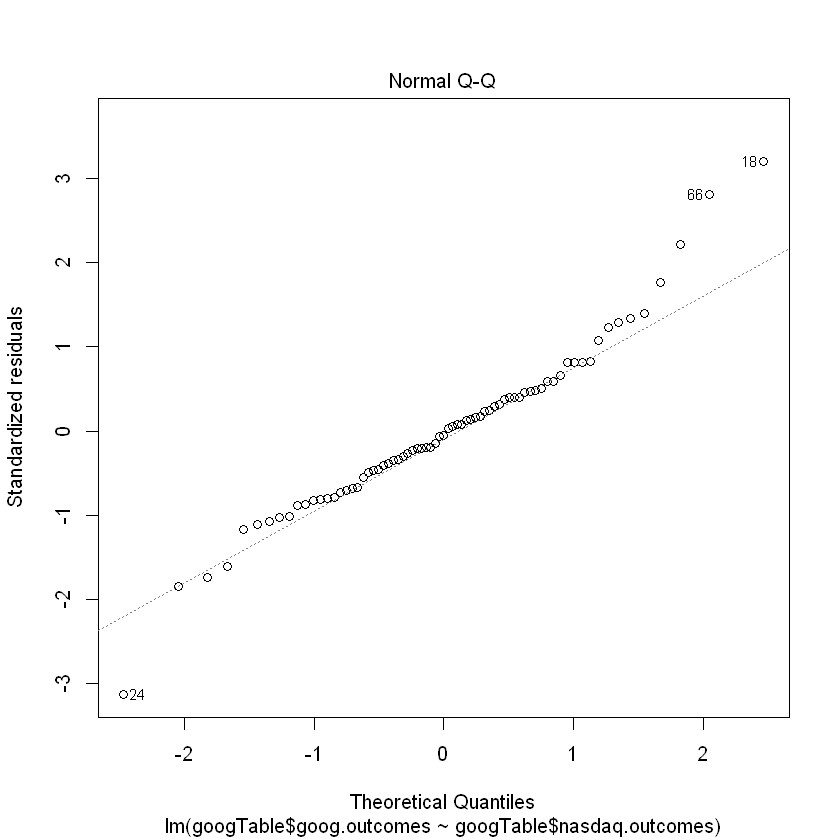

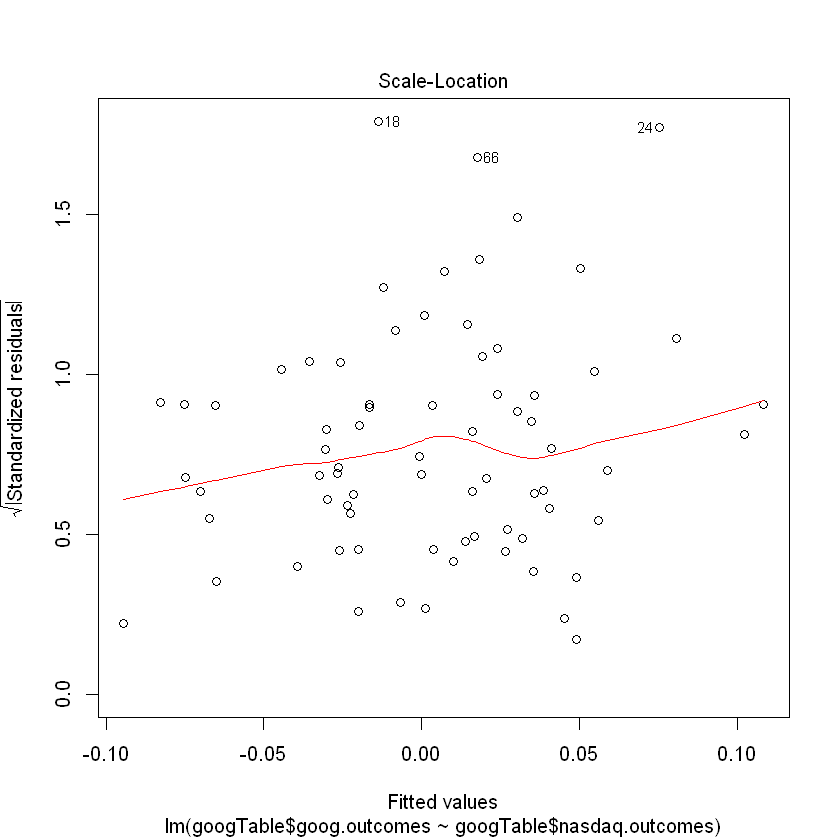

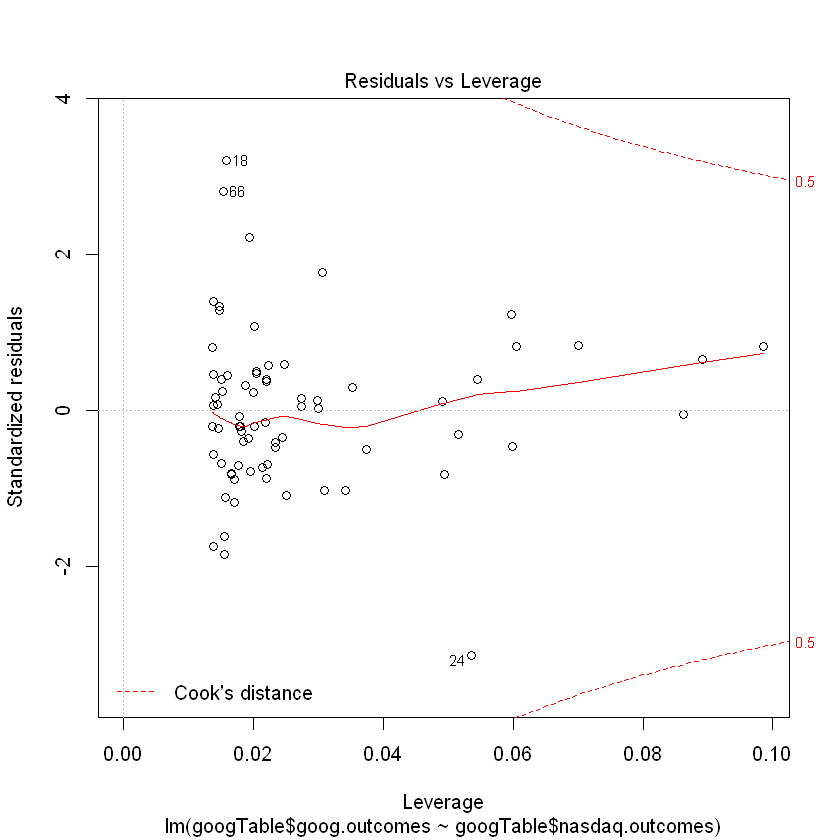

In [10]:
# Building a linear model
googTableM<-lm(googTable$goog.outcomes~googTable$nasdaq.outcomes)
summary(googTableM)
plot(googTableM)